# Analyzing Passive Acoustic Data with MHKiT

The following example illustrates how to read and analyze some basic parameters for passive acoustics data. Functionality to analyze .wav files recorded using hydrophones has been integrated into MHKiT to support analysis based on the IEC-TS 62600-40 standard.

The standard workflow for passive acoustics analysis is as follows:

1. Import .wav file
2. Calibrate data
3. Calculate spectral density
4. Calculate other parameters
5. Create plots

We'll import a couple plotting tools and the acoustics module:

In [1]:
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

from mhkit import acoustics

### Read in Hydrophone Measurements

All hydrophone .wav files can be read in MHKiT using a base function called `read_hydrophone` from the acoustics.io submodule. Because the sampling frequency is so fast, measurements are stored in the lowest memory format possible and need to be scaled and transformed to return the measurements in units of voltage or pressure.

The `read_hydrophone` function scales and transforms raw measurements given a few input parameters. Most parameters needed to convert the raw data are stored in the native .wav format header blocks, but two, the peak voltage ("peak_voltage") of the sensor's analog-to-digital converter (ADC) and file "start_time" (usually stored in the filename) are required. 

Two other inputs, the hydrophone sensitivity ("sensitivity") and an amplifier gain ("gain") can also be input. If a sensitivity value is provided, the function will convert voltage to pressure; otherwise the sensitivity(ies) can be provided later using a calibration curve. Gain should be provided if the instrument utilizes an amplifier gain (typically for custom hydrophone builds), which is then added to the sensitivity.

In [2]:
P = acoustics.io.read_hydrophone(
    "data/acoustics/RBW_6661_20240601_053114.wav", 
    peak_voltage=3, 
    sensitivity=-177, 
    gain=0, 
    start_time="2024-06-01T05:31:14"
)
# `P` is returned as an xarray DataArray, which allows easy handling of labeled multi-dimensional arrays. 
# In this case, the array represents sound pressure in Pascals (Pa) over time because the calibrated sensitivity was passed.
print(P)

<xarray.DataArray (time: 30720000)> Size: 246MB
array([0.31546374, 0.30229832, 0.32229963, ..., 0.08506887, 0.07291618,
       0.06278893])
Coordinates:
  * time     (time) datetime64[ns] 246MB 2024-06-01T05:31:14 ... 2024-06-01T0...
Attributes:
    units:        Pa
    sensitivity:  1.413e-09
    resolution:   9.89e-07
    valid_min:    -2123.837353
    valid_max:    2123.837353
    fs:           512000
    filename:     RBW_6661_20240601_053114


"Smart" hydrophones are those where the hydrophone element, pre-amplifier board, ADC, motherboard and memory card are sold in a single package. Companies that sell these often store metadata in the .wav file header, and MHKiT has a couple of wrapper functions for these hydrophones.

OceanSonics icListen and OceanInstruments Soundtrap are two common smart hydrophone models, with examples as follows.

For icListen datafiles, only the filename is necessary to provide to return file contents in units of pressure. The stored sensitivity calibration value can be overridden by setting the "sensitivity" input, and to return measurements in units of voltage, set `sensitivity` to None and `use_metadata` to False.

In [3]:
P = acoustics.io.read_iclisten("data/acoustics/RBW_6661_20240601_053114.wav")
V = acoustics.io.read_iclisten(
    "data/acoustics/RBW_6661_20240601_053114.wav", 
    sensitivity=None, 
    use_metadata=False
)

For Ocean Instruments Soundtrap datafiles, the filename and sensitivity should be provided to return the measurements in units of pressure. If the hydrophone has been calibrated, set the sensitivity to None to return the measurements in units of voltage.

In [4]:
P = acoustics.io.read_soundtrap("data/acoustics/6247.230204150508.wav", sensitivity=-177)
V = acoustics.io.read_soundtrap("data/acoustics/6247.230204150508.wav", sensitivity=None)

### Mean Square Sound Pressure Spectral Density

After the .wav file is read in, either in units of pressure or voltage, we calculate the mean square sound pressure spectral density (SPSD) of the timeseries using `sound_pressure_spectral_density`. This splits the timeseries into windows and uses fast Fourier transforms to convert the raw measurements into the frequency domain, with units of $Pa^2/Hz$ or $V^2/Hz$, depending on the input. The function takes the original datafile, the hydrophone's sampling rate ("fs"), which is stored as an attribute of the measurement timeseries, and a window size ("bin_length") in seconds as input.

The IEC-40 considers an acoustic sample to have a length of 1 second, so we'll set the bin length as such here.

In [5]:
# Create mean square spectral densities using 1 s bins.
spsd = acoustics.sound_pressure_spectral_density(V, V.fs, bin_length=1)

### Applying Calibration Curves

For conducting scientific-grade analysis, it is critical to use calibration curves to correct the SPSD calculations. Hydrophones should be calibrated (i.e., a sensitivity calibration curve should be generated for a hydrophone) every few years. The IEC-40 asks that a hydrophone be calibrated both before and after the test deployment.

A calibration curve consists of the hydrophone's sensitivity (in units of $dB$ rel $1$ $V^2/uPa^2$) vs frequency and should be applied to the spectral density we just calculated.

The easiest way to apply a sensitivity calibration curve in MHKiT is to first copy the calibration data into a CSV file, where the left column contains the calibrated frequencies and the right column contains the sensitivity values. Here we use the function in the following codeblock to read in a CSV file created with the column headers "Frequency" and "Analog Sensitivity".

In [6]:
import pandas as pd

def read_calibration_file(filename):
    calibration = pd.read_csv(filename, sep=",")
    calibration.index = calibration["Frequency"]
    calibration = calibration.to_xarray()
    return calibration["Analog Sensitivity"]

sensitivity_curve = read_calibration_file("data/acoustics/6247_calibration.csv")
print(sensitivity_curve)

<xarray.DataArray 'Analog Sensitivity' (Frequency: 40)> Size: 320B
array([-223.49, -220.8 , -218.13, -215.41, -212.68, -209.91, -207.12,
       -204.29, -201.45, -198.58, -195.69, -192.79, -189.85, -186.9 ,
       -183.93, -180.93, -177.92, -174.97, -172.16, -169.61, -167.69,
       -166.52, -165.96, -165.81, -165.85, -165.95, -166.05, -166.13,
       -166.2 , -166.25, -166.28, -166.29, -166.29, -166.27, -166.24,
       -166.17, -166.03, -165.79, -165.47, -164.87])
Coordinates:
  * Frequency  (Frequency) float64 320B 1.0 1.183 1.399 ... 500.3 591.8 700.0


Once we have the calibration data in an xarray DataArray, we can apply that to the SPSD using the `apply_calibration` function. Calibration curves typically do not cover the entire range of the hydrophone, so this function will linearly interpolate the missing values. A fill_value can be provided to extrapolate outside of the calibrated frequencies.

In [7]:
# Use last value in calibration curve for higher frequencies
fill_Sf = sensitivity_curve[-1].values
spsd = acoustics.apply_calibration(spsd, sensitivity_curve, fill_value=fill_Sf)

### Mean Square Sound Pressure Spectral Density Level

We can use the function `sound_pressure_spectral_density_level` to calculate the mean square sound pressure spectral density levels (SPSDLs) from the calibrated SPSD. This function converts absolute pressure into relative pressure in log-space, the traditional means with which we measure sound, in units of decibels relative to 1 uPa ($dB$ rel $1$ $uPa$), the standard for underwater sound. 
    
Sidenote: Sound in air is measured in decibels relative to 20 uPa, the minimum sound pressure humans can hear. To convert between "$dB$ rel $1$ $uPa$" and "$dB$ rel $20$ $uPa$", one simply needs to subtract 26 dB from the "$dB$ rel $1$ $uPa$" value.

In [8]:
spsdl = acoustics.sound_pressure_spectral_density_level(spsd)

Now that the SPSDL is calculated, we can create spectrograms, or waterfall plots, using the `plot_spectrogram` function in the graphics submodule. While spectrograms aren't required by the IEC-40, they are useful to do quality control so we can avoid using contaminated soundbytes in further analysis (like the boat noise shown in this one).

To do this, we'll give the function the minimum and maximum frequencies to plot, as well as keyword arguments supplied to the matplotlib `pcolormesh` function. For these measurements, we're setting fmin = 10 Hz, the minimum specified by the IEC-40, and fmax = 48,000 Hz, the Nyquist frequency for these data. 

Note, the IEC-40 requires a maximum frequency of 100,000 Hz, so a hydrophone capable of sampling faster than 200,000 Hz should be used for IEC testing.

In [9]:
# Show Nyquist frequency (maximum in frequency vector)
print(spsdl["freq"].max())

<xarray.DataArray 'freq' ()> Size: 8B
array(48000.)


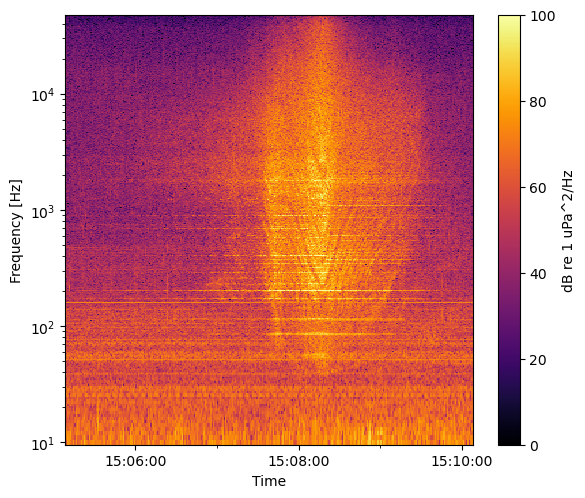

In [10]:
fmin = 10
fmax = 48000

# Create high resolution spectrogram
kwargs={"cmap": "inferno", "vmin": 0, "vmax": 100}
fig, ax = acoustics.graphics.plot_spectrogram(
    spsdl, fmin, fmax, **kwargs
)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=2))
ax.xaxis.set_minor_locator(mdates.MinuteLocator())


If you see something interesting in the spectrogram, the next step you should do is listen to the .wav file. This can tell you a lot about what you're looking at. If you listen to this file, you'll hear the boat cruising by around 3 minutes in.

Some audio players aren't able to play some hydrophone recodings (i.e. icListens), so be sure to try multiple if you can't hear anything in one particular player. Higher-end hydrophones tend to user higher ADC peak voltages, which will translate to quieter audio tracks. You can use the `export_audio` file in the io submodule to rescale these audio tracks and increase the gain if need be.

In [11]:
# Uncomment to save new file
filename = "sound1.wav"
#acoustics.io.export_audio(filename, P, gain=1)

### IEC-40 Stats

The IEC-40 requires a few aggregate statistics for characterizing the sound of marine energy devices. For the first, the IEC-40 asks for plots showing the 25%, 50%, and 75% quantiles of the SPSDL during specific marine energy device states. For current energy devices, the IEC-40 requires 10 SPSDL samples at a series of turbine states (braked, freewheel, 25% power, 50% power, 75% power, 100% power). For wave energy devices, the spec requires 30 SPSDL samples in each wave height and period bin observed.

For this example notebook we'll keep it simple and use a random set of 30 samples and collate them together. Otherwise one can pick and choose which to use. Then we can find the median and quantiles of those 30 samples.

Text(0.5, 1.0, 'Median and Quantile Sound Pressure Spectral Density Level')

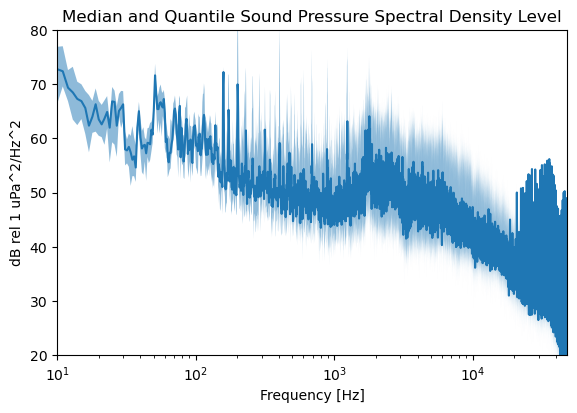

In [12]:
import random
samples = random.sample(range(spsdl["time"].size), 30)
spsdl_clip = spsdl.isel(time=samples)

spsdl_median = spsdl_clip.median("time")
spsdl_q25 = spsdl_clip.quantile(0.25, "time")
spsdl_q75 = spsdl_clip.quantile(0.75, "time")

# Plot medians and quantiles
fig, ax = acoustics.graphics.plot_spectra(spsdl_median, fmin, fmax)
ax.fill_between(
    spsdl_clip["freq"],
    spsdl_q25,
    spsdl_q75,
    alpha=0.5,
    facecolor="C0",
    edgecolor=None
)
ax.set(ylabel="dB rel 1 uPa^2/Hz^2", ylim=(20, 80))
ax.set_title("Median and Quantile Sound Pressure Spectral Density Level")

### Window Aggregating

If desired, one can also group a series of measurements into blocks of time. In the following block, we'll take our 5 minutes of measurements, `time_aggregate` them into 30 second intervals, and find the median, 25% and 75% quantiles of each interval. We then plot the stats of the first time block (block #0).

In [13]:
# Time average into 30 s windows
window = 30
spsdl_50 = acoustics.time_aggregate(spsdl, window, method="median")
spsdl_25 = acoustics.time_aggregate(spsdl, window, method={"quantile":0.25})
spsdl_75 = acoustics.time_aggregate(spsdl, window, method={"quantile":0.75})

We can then using the `plot_spectra` function in the graphics submodule to plot the median and quantiles of the first 30 s window.

Text(0.5, 1.0, 'Median and Quantile Sound Pressure Spectral Density Level')

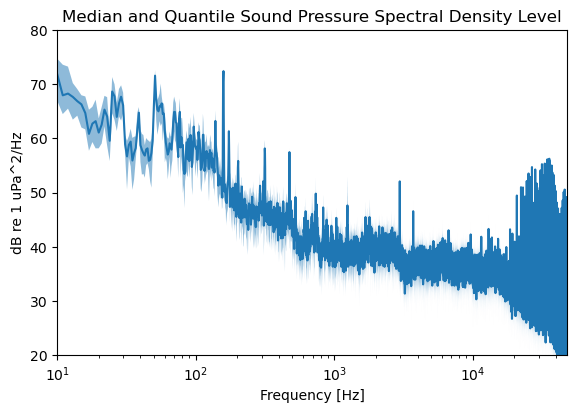

In [14]:
# Plot medians and quantiles
fig, ax = acoustics.graphics.plot_spectra(spsdl_50[0], fmin, fmax)
ax.fill_between(
    spsdl_50["freq"],
    spsdl_25[0],
    spsdl_75[0],
    alpha=0.5,
    facecolor="C0",
    edgecolor=None
)
ax.set_ylim(20, 80)
ax.set_title("Median and Quantile Sound Pressure Spectral Density Level")

### Band Averaging

Analysis can also be completed by grouping the data into specific frequency bands, called "band aggregating" here. In other words, instead of aggregating by the time dimension, we aggregate by the frequency dimension. The `band_aggregate` function operates by taking the SPSDL and grouping it based on a specified octave.

If one wants to do more analysis on the grouped frequency bands than the simple statistical methods that xarray offers, it is possible to use the "map" function to apply a custom function to a file. In the following block of code, we find the empirical quantile function (the empirical version of the cumulative distribution function, CDF) to each decidecade band (10^(1/10)) frequency band and plot the 160 Hz band. 

c:\users\mcve343\mhkit-python\mhkit\acoustics\analysis.py:78: UserWarning: `fmax` = 100000 is greater than the Nyquist frequency. Settingfmax = 48000.0
  warnings.warn(


[Text(0.5, 1.0, '1000.0 Hz'),
 Text(0, 0.5, 'Exceedance Probability'),
 Text(0.5, 0, 'Decidecade SPSDL [dB re 1 uPa^2/Hz]')]

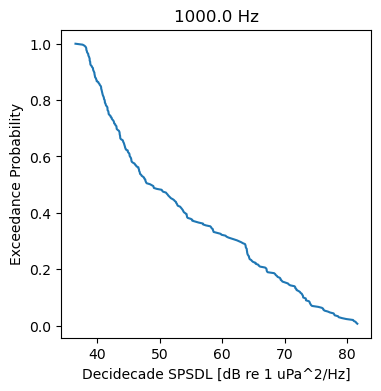

In [15]:
def quantile_function(x):
    # Empirical CDF/Quantile Function/Exceedance Probability
    # Use the median of the coordinate we're grouped in
    x = x.median("freq")
    # Squeeze to remove frequency dimension
    shape = np.shape(x)
    x_sorted = np.sort(np.squeeze(x))
    # calculate the proportional values of samples
    p = 1.0 - np.arange(len(x)) / (len(x) + 1)
    # recreate dataarray
    x = x.assign_coords({"time": p}).rename({"time": "probability"})
    x.values = np.reshape(x_sorted, shape)
    return x


cdfs = acoustics.band_aggregate(spsdl, octave=10, base=10, method={"map": quantile_function})
# Plot
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(cdfs[20].values, cdfs["probability"].values)
ax.set(
    title=f"{np.round(cdfs['freq_bins'][20].values, 2)} Hz",
    ylabel="Exceedance Probability",
    xlabel="Decidecade SPSDL [dB re 1 uPa^2/Hz]",
)

Another plot that is useful for IEC-40 compliance are decidecade boxplots of the SPSDL. We can also use the aggregate methods to apply plotting functions, like matplotlib's native boxplot. In this case, we supply the "map" function and an iterable of the custom function inputs, in this case the figure axes we want to use to plot.

This plot shows significant spread in sound measurements due to the vessel noise, with whiskers stretching to the 1st and 99th quantiles. Generally any significant spread in a frequency band is caused by sound generated by an external source, and not the ambient soundscape.

c:\users\mcve343\mhkit-python\mhkit\acoustics\analysis.py:78: UserWarning: `fmax` = 100000 is greater than the Nyquist frequency. Settingfmax = 48000.0
  warnings.warn(


[[<matplotlib.axis.XTick at 0x299b5d1b5d0>,
 [Text(0.0, 0, '0'),
  Text(1.0, 0, '1'),
  Text(2.0, 0, '2'),
  Text(3.0, 0, '3'),
  Text(4.0, 0, '4'),
  Text(5.0, 0, '5')],
 (0.95, 4.8),
 (20.0, 100.0),
 Text(0.5, 0, 'log(Frequency) [Hz]'),
 Text(0, 0.5, 'Decidecade SPSDL [dB re 1 uPa^2/Hz]')]

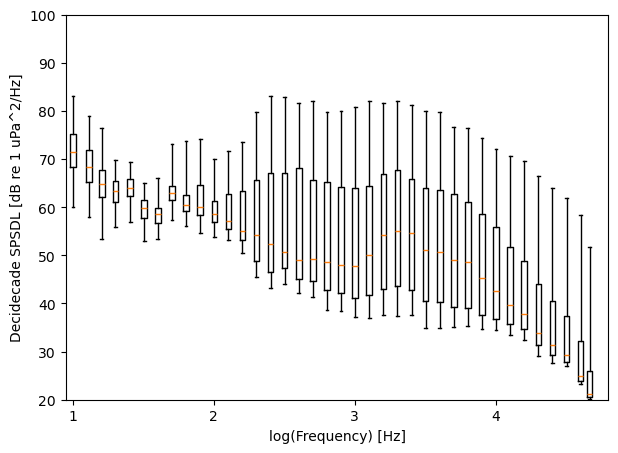

In [25]:
def boxplot(x, ax):
    # Use the median of the coordinate we're grouped in
    freq = x["freq"].median()
    x = x.mean("freq")
    # Create boxplots
    ax.boxplot(
        x.values,
        whis=(1, 99),
        showfliers=False,
        positions=[np.log10(freq.values)],
        widths=0.04,
        flierprops={"marker": ".", "markersize": 2},
    )
    return x

fig, ax = plt.subplots(figsize=(7, 5))
acoustics.band_aggregate(
    spsdl, octave=10, base=10, method={"map": (boxplot, [ax])}
)
xticks = np.linspace(0, 5, 6)
ax.set(
    xticks=xticks,
    xticklabels=xticks.astype(int),
    xlim=(0.95, 4.8),
    ylim=(20, 100),
    xlabel="log(Frequency) [Hz]",
    ylabel="Decidecade SPSDL [dB re 1 uPa^2/Hz]",
)

### Sound Pressure Level

The IEC-40 has two requirements considering calculations of sound pressure level (SPL). We'll first calculate the SPL over the full frequency range of the turbine and/or hydrophone. The IEC-40 asks that the range be set from 10 to 100,000 Hz, though the lower limit can be increased due to flow noise or low frequency signal loss due to shallow water. 

#### Shallow water cutoff frequency
Low frequency sound is absorbed into the seabed in shallow water depths. We can use the function `minimum_frequency` to get an approximation of what our minimum frequency should be. This approximation uses the water depth, estimates of the in-water sound speed and sea/riverbed sound speed to determine what the cutoff frequency will be. The difficult part with this approximation is figuring out the speed of sound in the bed material, which generally ranges from 1450-1800 m/s. 

This function should only be used as a rough approximation and sanity check if significant attenuation is seen at various low frequencies and harmonics.

In [17]:
depths = np.array([1, 5, 10, 20, 40, 80])
fmin = acoustics.minimum_frequency(water_depth=depths, c=1500, c_seabed=1700)

print("Depth [m], Freq [Hz]")
for d, f in zip(depths, fmin):
    print(f"{d}, {f:0.1f}")

Depth [m], Freq [Hz]
1, 796.9
5, 159.4
10, 79.7
20, 39.8
40, 19.9
80, 10.0


Though the IEC-40 says we should default to a minimum frequency of 10 Hz, as you can see above, unless we're measuring from a depth of around 80 +/- 10 m, our minimum frequency should be higher. One can play around with the bed soundspeed to see how these change with varying bed densities/compositions.

#### Flow Noise
Flow noise, or psuedo-sound, is the other reason to increase the minimum frequency of our SPL measurements. Flow noise is caused by one of three things: turbulence advected past the hydrophone element, turbulence caused by the hydrophone element, and the sensitivity of the hydrophone element to temperature inhomogeneities in the advected flow. Flow noise is most noticeably apparent when flow speeds increase above 0.5 m/s, seen in spectrograms as a logarithmic increase in pressure with decreasing frequency.

#### Cumulative SPL

The particular data shown here was measured in around 8-10 m of water, and a mix of mild flow noise below 20 Hz and low frequency attenutation below ~50 Hz can be seen in the spectrogram. We'll again use the Nyquist frequency of 48,000 Hz.

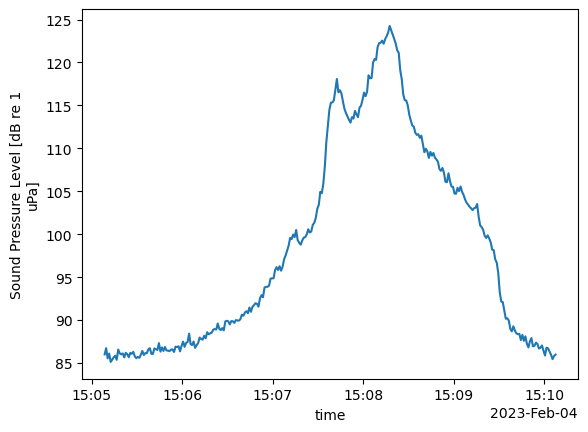

In [18]:
# Sound pressure level
fmin = 50
fmax = 48000

spl = acoustics.sound_pressure_level(spsd, fmin, fmax)
spl.plot()

So we can see our cumulative SPL start out at 86 dB and then peak at 120 dB as the boat drives by. If you haven't listened to the audio track, this peak SPL of 125 dB rel 1 uPa (underwater) is equivalent to 99 dB rel 20 uPa (air). For reference, the OSHA time limit for workers experiencing 100 dB rel 20 uPa of sound is 2 hours. Vessel traffic quite loud and is the largest contributor to noise in the marine environment.

### Decidecade Sound Pressure Levels

The last stat that IEC-40 requests are the decidecade SPLs. Note that the IEC-40 incorrectly labels these as synonymous with the third-octave SPLs, following the relevant ANSI specifications. 

To explain, a true octave is a frequency band where the upper frequency is double (2^1) that of the lower frequency. Third octaves are often measured because mammals to have evolved to interpret sound at this bandwidth. The one-third octave is a frequency band where the upper frequency is 2^(1/3) = 1.25992 times the lower frequency. The decidecade band referenced by the IEC-40 refers to a frequency band with a bandwidth of 10^(1/10) = 1.25892. Though quite similar, wherever the IEC-40 says third octave, they actually mean the decidecade bandwidth.

We can calculate the SPL in each decidecade band using the function `decidecade_sound_pressure_level`. This function uses the same calculation as `sound_pressure_level` above and runs it on each tenth octave band. It returns 1 SPL in each frequency band every timestamp, so our boxplots show 5 minutes worth of SPL measurements in each decidecade band. You'll notice a similar spread as in the SPSDL boxplots, especially in the upper quantile. Boats are loud.

[[<matplotlib.axis.XTick at 0x299b5698510>,
 [Text(0.0, 0, '0'),
  Text(1.0, 0, '1'),
  Text(2.0, 0, '2'),
  Text(3.0, 0, '3'),
  Text(4.0, 0, '4'),
  Text(5.0, 0, '5')],
 (1.5, 4.8),
 (50.0, 120.0),
 Text(0.5, 0, 'log(Frequency) [Hz]'),
 Text(0, 0.5, 'Decidecade SPL [dB re 1 uPa]')]

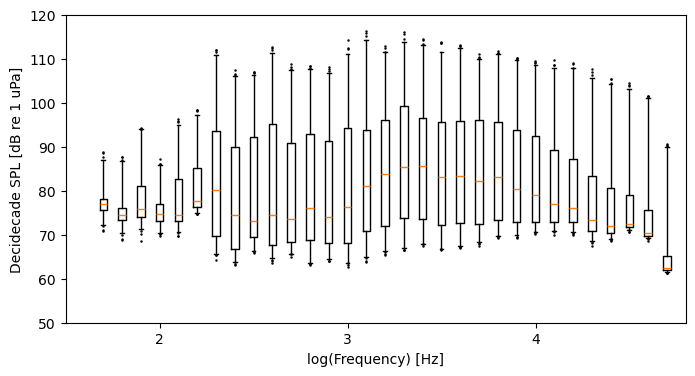

In [23]:
# Decidecade octave sound pressure level (also interquartile)
spl10 = acoustics.decidecade_sound_pressure_level(spsd, fmin, fmax)

# Plot the decidecade sound pressure level
fig, ax = plt.subplots(figsize=(8, 4))
ax.boxplot(
    spl10.values,
    whis=(1, 99),
    showfliers=True,
    positions=np.log10(spl10["freq_bins"].values),
    widths=0.04,
    flierprops={"marker": ".", "markersize": 1.5},
)
xticks = np.linspace(0, 5, 6)
ax.set(
    xticks=xticks,
    xticklabels=xticks.astype(int),
    xlim=(1.5, 4.8),
    ylim=(50, 120),
    xlabel="log(Frequency) [Hz]",
    ylabel="Decidecade SPL [dB re 1 uPa]",
)

### Third Octave Sound Pressure Level

One can also calculate the true 1/3 octave SPLs using `third_octave_sound_pressure_level`. Note the results are quite similar to `decidecade_sound_pressure_level`.

[[<matplotlib.axis.XTick at 0x299afe4fa50>,
 [Text(0.0, 0, '0'),
  Text(1.0, 0, '1'),
  Text(2.0, 0, '2'),
  Text(3.0, 0, '3'),
  Text(4.0, 0, '4'),
  Text(5.0, 0, '5')],
 (1.5, 4.8),
 (50.0, 130.0),
 Text(0.5, 0, 'log(Frequency) [Hz]'),
 Text(0, 0.5, 'Decidecade SPL [dB re 1 uPa]')]

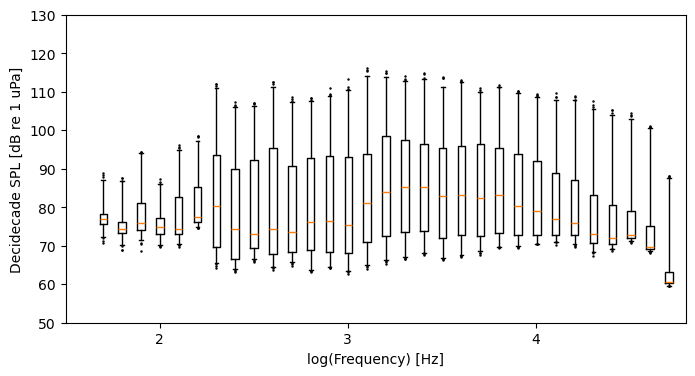

In [20]:
# Median third octave sound pressure level
spl3 = acoustics.third_octave_sound_pressure_level(spsd, fmin, fmax)

fig, ax = plt.subplots(figsize=(8, 4))
ax.boxplot(
    spl3.values,
    whis=(1, 99),
    showfliers=True,
    positions=np.log10(spl3["freq_bins"].values),
    widths=0.04,
    flierprops={"marker": ".", "markersize": 1.5},
)
xticks = np.linspace(0, 5, 6)
ax.set(
    xticks=xticks,
    xticklabels=xticks.astype(int),
    xlim=(1.5, 4.8),
    ylim=(50, 130),
    xlabel="log(Frequency) [Hz]",
    ylabel="Decidecade SPL [dB re 1 uPa]",
)